# Random forest

Exercice :

- Reprendre ce qui a été vu avec le Titanic pour estimer le prix de vente des maisons.

In [1]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .master('spark://localhost:7077') \
    .appName('House-PrizeBCO') \
    .getOrCreate()
sc = spark.sparkContext

Dataset : https://www.kaggle.com/harlfoxem/housesalesprediction

https://www.kaggle.com/madislemsalu/predicting-housing-prices-in-king-county-usa 

https://www.silect.is/blog/2019/4/2/random-forest-in-spark-ml

https://gist.github.com/bfraiche/99f906ce9754059942938a704c78738d

In [3]:
!hdfs dfs -ls /demo/house-prize

Found 2 items
-rw-r--r--   1 root supergroup     460676 2020-11-26 12:40 /demo/house-prize/house-prize-train.csv
-rw-r--r--   1 root supergroup    2515206 2020-11-26 12:40 /demo/house-prize/kc_house_data.csv


In [4]:
#!hdfs dfs -copyFromLocal -f /root/ipynb/data/* /demo/

In [5]:
df = (spark.read.format('csv')\
             .option('header', 'true')\
             .option('inferSchema', 'true')\
             .load("/demo/house-prize/kc_house_data.csv"))
df.createOrReplaceTempView("kings_county_housing")
# Pull in the data
#df = spark.sql("SELECT * FROM kings_county_housing")

In [6]:
df.printSchema()

root
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- price: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- yr_built: integer (nullable = true)
 |-- yr_renovated: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)



In [7]:
df.describe().toPandas()

,summary,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,count,21613,21613,21613,21613,21613,21613,21613,21613,21613,...,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613
1,mean,4.580301520864988E9,None,540088.1417665294,3.37084162309721,2.1147573219821405,2079.8997362698374,15106.967565816869,1.4943089807060566,0.007541757275713691,...,7.656873178179799,1788.3906907879516,291.5090454818859,1971.0051357978994,84.40225790033776,98077.93980474715,47.56005251931704,-122.21389640494083,1986.552491556008,12768.455651691113
2,stddev,2.8765655713120522E9,None,367127.19648270035,0.930061831147451,0.770163157217741,918.4408970468096,41420.51151513551,0.5399888951423489,0.08651719772788748,...,1.1754587569743344,828.0909776519175,442.57504267746685,29.373410802386243,401.67924001917504,53.505026257472466,0.13856371024192368,0.14082834238139288,685.3913042527788,27304.179631338524
3,min,1000102,20140502T000000,75000.0,0,0.0,290,520,1.0,0,...,1,290,0,1900,0,98001,47.1559,-122.519,399,651
4,max,9900000190,20150527T000000,7700000.0,33,8.0,13540,1651359,3.5,1,...,13,9410,4820,2015,2015,98199,47.7776,-121.315,6210,871200


In [8]:
df = df.withColumnRenamed("price", "label")
df.printSchema()

root
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- label: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- yr_built: integer (nullable = true)
 |-- yr_renovated: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)



In [9]:
df.columns

['id',
 'date',
 'label',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [10]:
#Define the workflow
feature_list = []
for col in df.columns:
    if col in ['id', 'label', 'date']:
        continue
    else:
        feature_list.append(col)
#feature_list=['MSSubClass', 'BedroomAbvGr', 'LotArea']        
feature_list

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [11]:
assembler = VectorAssembler(inputCols=feature_list, outputCol="features")
transformed_data = assembler.transform(df)
transformed_data.toPandas().head(3)

,id,date,label,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,features
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,"[3.0, 1.0, 1180.0, 5650.0, 1.0, 0.0, 0.0, 3.0,..."
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,"[3.0, 2.25, 2570.0, 7242.0, 2.0, 0.0, 0.0, 3.0..."
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,"[2.0, 1.0, 770.0, 10000.0, 1.0, 0.0, 0.0, 3.0,..."


In [12]:
np.linspace(start = 10, stop = 20, num = 5)

array([10. , 12.5, 15. , 17.5, 20. ])

In [13]:
[int(x) for x in np.linspace(start = 10, stop = 20, num = 5)]

[10, 12, 15, 17, 20]

In [14]:
rf = RandomForestRegressor(labelCol="label", featuresCol="features")

# Create a pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Hyperparameter tuning
# paramGrid = ParamGridBuilder() \
#     .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
#     .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
#     .build()

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)

(trainingData, testData) = df.randomSplit([0.8, 0.2])

In [15]:
cvModel = crossval.fit(trainingData)

In [16]:
bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[1]
bestModel.featureImportances

SparseVector(18, {0: 0.0123, 1: 0.0441, 2: 0.1892, 3: 0.0102, 4: 0.0027, 5: 0.022, 6: 0.0352, 7: 0.0051, 8: 0.2165, 9: 0.07, 10: 0.0191, 11: 0.0304, 12: 0.003, 13: 0.0212, 14: 0.1503, 15: 0.0607, 16: 0.0953, 17: 0.0126})

In [17]:
dtm = bestPipeline.stages[-1] # you estimator is the last stage in the pipeline
# hence the DecisionTreeClassifierModel will be the last transformer in the PipelineModel object 
dtm.explainParams().split('\n')

['bootstrap: Whether bootstrap samples are used when building trees. (default: True)',
 'cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)',
 'checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)',
 "featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3

In [18]:
# Evaluate on TRAIN
predictions = cvModel.transform(trainData)
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
rmse

In [19]:
# Evaluate on TEST
predictions = cvModel.transform(testData)
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
rmse

167229.93811703307

RMSE origine : 167229.93811703307

In [20]:
rfPred = cvModel.transform(df)
rfResult = rfPred.toPandas()

In [21]:
rfResult[['label', 'prediction']]

,label,prediction
0,221900.0,248394.526657
1,538000.0,495461.578246
2,180000.0,317260.854747
3,604000.0,482149.447761
4,510000.0,529924.774911
...,...,...
21608,360000.0,438693.900285
21609,400000.0,422266.757160
21610,402101.0,377710.248196
21611,400000.0,452507.104665


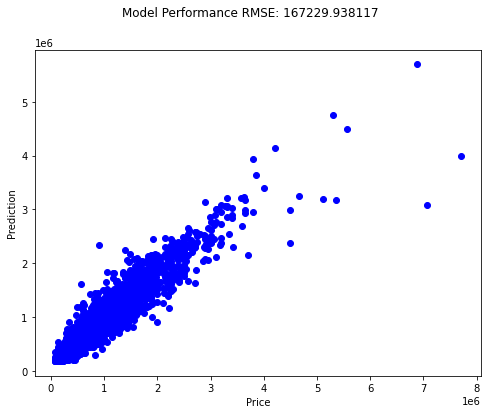

numTrees -  20
maxDepth -  10


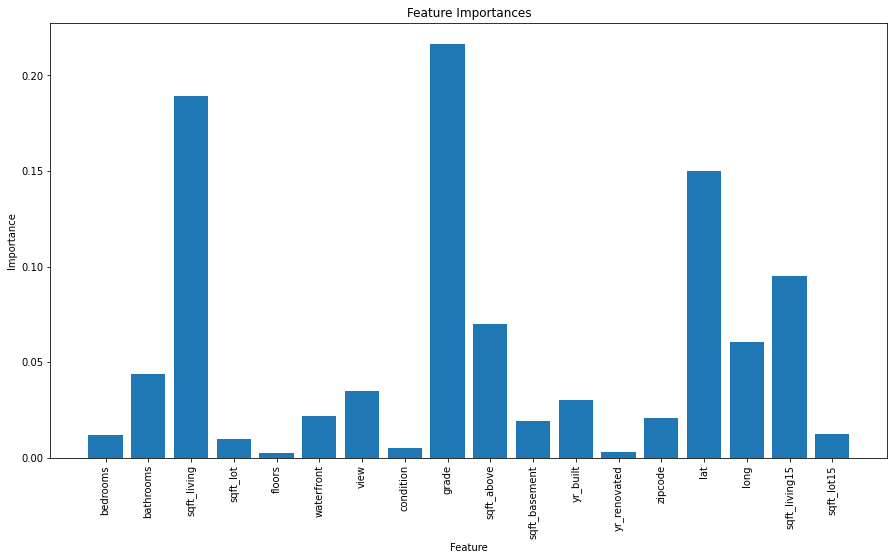

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(rfResult.label, rfResult.prediction, 'bo')
plt.xlabel('Price')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

round(233941.72 / rmse, 1) # factor of improvement over baseline

# Feature importance
bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[1]

importances = bestModel.featureImportances

x_values = list(range(len(importances)))
plt.figure(figsize=(15, 8))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

# Best hyperparameters
print('numTrees - ', bestModel.getNumTrees)
print('maxDepth - ', bestModel.getOrDefault('maxDepth'))

In [23]:
sc.stop()

## Exercice
Essayer avec GBTClassifier https://spark.apache.org/docs/latest/ml-classification-regression.html#gradient-boosted-trees-gbts

Et voir si cela améliore les performances